In [25]:
import sys
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [26]:
# import os
# from google.colab import files
# uploaded = files.upload()
# dst ='image.jpg' 
# os.rename(list(uploaded.keys())[0], dst)

In [27]:
# import os
# from google.colab import files
# uploaded = files.upload()
# dst ='movie.mp4' 
# os.rename(list(uploaded.keys())[0], dst)

In [166]:
# damage colors(BGR)
elementColors = dict()
elementColors['anemo'] = (208, 255, 120)
elementColors['geo'] = (105, 198, 243)
elementColors['electro'] = (255, 139, 222)
elementColors['physical'] = (255, 255, 255)
elementColors['pyro'] = (0, 158, 243)
elementColors['cyro'] = (255, 255, 164)
elementColors['hydro'] = (251, 216, 63)
elementColorHSV = dict()
elementColorHSV['anemo'] = (112, 141, 255)
elementColorHSV['geo'] = (29, 147, 250)
elementColorHSV['electro'] = (200, 124, 248)
elementColorHSV['physical'] = (71, 3, 255)
elementColorHSV['pyro'] = ( 27, 253, 240)
elementColorHSV['cyro'] = (128,  94, 255)
elementColorHSV['hydro'] = (136, 194, 250)

resizeScale = 0.5
colorKey = "cyro"

In [167]:
def rectangleScaled(im, start, end, color, thickness=1):
    start = (int(start[0] / resizeScale), int(start[1] / resizeScale))
    end = (int(end[0] / resizeScale), int(end[1] / resizeScale))
    cv2.rectangle(im, start, end, color, thickness)

def restoreRectangle(rect):
    return (int(rect[0] / resizeScale), int(rect[1] / resizeScale), int(rect[2] / resizeScale), int(rect[3] / resizeScale))

In [168]:
templates = []
for i in range(10):
  templates.append(cv2.resize(cv2.imread('./numberanalyzer/templates/' + str(i) + '.png', 0), (36, 36)))

def matchingNumber(im):
  maxVal_All = 999999999999999
  num_dsp = 0
  resizedIm = cv2.resize(im, (36, 36))
  for i in range(10):

    result= abs(resizedIm - templates[i]).sum() # cv2.matchTemplate(resizedIm,templates[i],cv2.TM_CCOEFF_NORMED)
    # mmr=cv2.minMaxLoc(result)
    maxVal=result  
        
    if maxVal < maxVal_All:
        num_dsp = i
        maxVal_All = maxVal
    
  return num_dsp
            


In [169]:
def getNumber(original, resized, rect):
  global imageCounter
  x, y, w, h = restoreRectangle(rect)
  height = 150
  scale = height / h
  partImage = cv2.resize(original[y:y+h, x:x+w, :], (int(height / h * w), height))
  
  rangeW = 10
  color = elementColors[colorKey]
  partImage = cv2.inRange(partImage, (max(color[0] - rangeW, 0), max(color[1] - rangeW, 0), max(color[2] - rangeW, 0)), (min(255, color[0] + rangeW), min(255, color[1] + rangeW), min(255, color[2] + rangeW)))

  closing = cv2.dilate(partImage,(2, 2),iterations = 1)
  thresh = cv2.adaptiveThreshold(closing, 255, 1, 1, 5, 2)
  contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  
  if len(contours) < 4:
    return 0
  lists = []
  for cnt in contours:
    nextRect = cv2.boundingRect(cnt)
    x2, y2, w2, h2 = nextRect
    if h2 < 0.8 * height or w2 / h2 > 1:
      continue
    red = (255, 0, 0)
    # cv2.imwrite("./output/{}.png".format(imageCounter), closing[y2:y2+h2,x2:x2+w2])
    num = matchingNumber(closing[y2:y2+h2,x2:x2+w2])
    lists.append((num, x2))
    imageCounter += 1
    cv2.rectangle(original, (x + int(x2 / scale), y + int(y2 / scale)), (x + int((x2 + w2) / scale), y + int((y2 + h2) / scale)), red, 2)
  
  lists.sort(key=lambda x: -x[1])
  total = 0
  for i, value in enumerate(lists):
    total += value[0] * (10 ** i) 

  return total

In [170]:
imageCounter = 0
def outputNumberBinaryImage(im, rect):
  global imageCounter
  x,y,w,h = rect
  outputImage = im[y:y+h, x:x+w]
  closing = cv2.dilate(outputImage,(4, 4),iterations = 1)
  cv2.imwrite("./output/{}_{}.png".format(colorKey, imageCounter), closing)
  imageCounter += 1

In [171]:


def drawContours(im, resized, parcent, width, height):
  global prevFrameNumber, resizeScale, textpos
  
  rangeW = 20
  color = elementColorHSV[colorKey]
  inrange = cv2.inRange(resized, (max(color[0] - 5, 0), max(color[1] - 10, 0), 200), (min(255, color[0] + 5), min(255, color[1] + 10), 255))
  # for key, color in elementColors.items():
  #   nextInrange = cv2.inRange(im, (color[0] - rangeW, color[1] - rangeW, color[2] - rangeW), (color[0] + rangeW, color[1] + rangeW, color[2] + rangeW))
  #   inrange = np.maximum(nextInrange, inrange)

  # blur = cv2.GaussianBlur(inrange, (5, 5), 0)
  thresh = cv2.adaptiveThreshold(inrange, 255, 1, 1, 7, 2)

  contours, _ = cv2.findContours(
      thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  
  frameContours = []
  
  nextFrameNumber = []

  for cnt in contours:
    rect = cv2.boundingRect(cnt.astype(np.int32))
    x, y, w, h = rect
    frameContours.append((x + w / 2, y + h / 2))
    

    if h < 2 or w / (h * 0.8) < 3:
      continue
    # flag = False
    # for px, py in prevFrameContours:
    #   if abs(px - (x + w / 2)) < 50 and abs(py - (y - h / 2)) < 50:
    #     flag = True
    #     break
    # if flag:
    #   continue
    
    # outputNumberBinaryImage(inrange, rect)
    red = (0, 0, 255)
    num = getNumber(im, inrange, rect)
    if num < 1000:
      continue
    rectangleScaled(im, (x, y), (x + w, y + h), red, 2)
    # cv2.line(im, (int(width * parcent), height), (int(width * parcent), int(height - num / 100000 * height)), red, 5)
    cv2.putText(im, str(num), (int((x + w/2) / resizeScale), int((y+h * 2) / resizeScale)), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 5)
    nextFrameNumber.append(num)

    prevFrameExist = False
    for prevNum in prevFrameNumber:
      if num == prevNum:
        prevFrameExist = True
        break
    
    if not prevFrameExist:
        textQueue.put(str(num))
        if (textQueue.qsize() == 20):
          textQueue.get()
        break
  
  prevFrameNumber = nextFrameNumber
  index = 0
  for index, text in enumerate(list(textQueue.queue)):
    cv2.putText(im, text, (0, index * 50 + 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 5)
    index += 1
  
  prevFrameContours = frameContours

  return im

In [186]:
filename = "videos/tartagria"
cap = cv2.VideoCapture('./{}.mp4'.format(filename))
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
frame_rate = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# out = cv2.VideoWriter('./{}_output.mp4'.format(filename), fourcc, frame_rate, (width, height))
colorKey = "hydro"
prevFrameNumber = []
import queue
textQueue = queue.Queue()

count = 0
imageCounter = 0

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

store_frame = None

while(cap.isOpened()):
  ret, frame = cap.read()
  count += 1
  if count % 24 == 0:
    print(count / frame_count * 100, '%')
  if (not(ret)):
    break
  
  color = elementColors[colorKey]
  rangeW = 7
  resized = cv2.resize(frame, (int(frame.shape[1] * resizeScale), int(frame.shape[0] * resizeScale)))
  resized2 = cv2.cvtColor(resized, cv2.COLOR_BGR2HSV_FULL)
  # res = drawContours(frame, resized, count / frame_count, frame.shape[1], frame.shape[0])

  
  color = elementColorHSV[colorKey]
  inrange = cv2.inRange(resized2, (max(color[0] - 5, 0), max(color[1] - 40, 0), max(color[1] - 40, 0)), (min(255, color[0] + 5), min(255, color[1] + 40), min(color[1] + 40, 255)))
  resized = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
  resized = resized // 5 + inrange // 5 * 4

  # inrange = cv2.inRange(resized, (max(color[0] - rangeW, 0), max(color[1] - rangeW, 0), max(color[2] - rangeW, 0)), (min(255, color[0] + rangeW), min(255, color[1] + rangeW), min(255, color[2] + rangeW)))
  # # for key, color in elementColors.items():
  # #   nextInrange = cv2.inRange(im, (color[0] - rangeW, color[1] - rangeW, color[2] - rangeW), (color[0] + rangeW, color[1] + rangeW, color[2] + rangeW))
  # #   inrange = np.maximum(nextInrange, inrange)

  # # blur = cv2.GaussianBlur(inrange, (5, 5), 0)
  # res = cv2.adaptiveThreshold(inrange, 255, 1, 1, 7, 2)

  # gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  # out.write(res)
  cv2.imshow("frame", resized)
  
  if cv2.waitKey(1) & 0xFF == ord('q'):
      store_frame = frame
      break

# out.release()
cap.release()
cv2.destroyAllWindows()
    


0.11920727164357026 %
0.2384145432871405 %
0.35762181493071077 %
0.476829086574281 %
0.5960363582178513 %
0.7152436298614215 %
0.8344509015049918 %
0.953658173148562 %
1.0728654447921324 %
1.1920727164357026 %
1.311279988079273 %
1.430487259722843 %
1.5496945313664132 %
1.6689018030099836 %
1.7881090746535537 %
1.907316346297124 %
2.0265236179406942 %
2.145730889584265 %
2.264938161227835 %
2.384145432871405 %
2.5033527045149757 %
2.622559976158546 %
2.741767247802116 %
2.860974519445686 %
2.9801817910892563 %
3.0993890627328264 %
3.2185963343763966 %
3.337803606019967 %
3.4570108776635378 %
3.5762181493071075 %
3.695425420950678 %
3.814632692594248 %
3.933839964237819 %
4.0530472358813885 %
4.1722545075249595 %
4.29146177916853 %
4.4106690508121 %
4.52987632245567 %
4.64908359409924 %
4.76829086574281 %
4.88749813738638 %
5.006705409029951 %
5.125912680673521 %
5.245119952317092 %
5.364327223960662 %
5.483534495604232 %
5.602741767247802 %
5.721949038891372 %
5.841156310534942 %
5.960

[166  30 152]


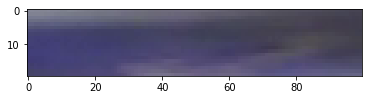

In [176]:

plt.imshow(store_frame[490:510,150:250,::-1])
print(cv2.cvtColor(store_frame, cv2.COLOR_BGR2HSV_FULL)[490,150,:])

In [174]:

cv2.destroyAllWindows()